In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import odeint

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [2]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Concatenate, Add, Multiply,Average, Subtract
from tensorflow.keras.models import Model
import traffic_data_generator
import traffic_util

Fix the random seeds in numpy, tensorlfow

In [3]:
import random as rn

rand_seed=116
rn.seed(rand_seed)
np.random.seed(rand_seed)
tf.random.set_seed(rand_seed)


In [4]:
class Xing_1995 ():
    def __init__(self,delta_t,T1,T2):
        self.alpha=.5
        self.beta=.05
        self.T1=T1
        self.T2=T2
        self.delta_t=delta_t
        
    def acc_func(self,v,x):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1=np.max([v.shape[1]-T1_n_steps,0])
        i_T2=np.max([x.shape[1]-T2_n_steps,0])
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        D_n=7+.5*v[1,i_T2]
        return self.alpha*delta_v+self.beta*(delta_x-D_n)

In [5]:
class GHR ():
    def __init__(self, c, m,l,T1,T2):
        self.c=c
        self.m=m
        self.l=l
        self.T1=T1
        self.T2=T2
        
    def acc_func(self,v,delta_x, delta_v):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1=np.max([v.shape[1]-T1_n_steps,0])
        i_T2=np.max([x.shape[1]-T2_n_steps,0])
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        if abs(delta_x)<10**-12:
            delta_x=10**-12
        return v[0,0]**self.m*self.c*delta_v/delta_x**self.l

In [6]:
class Helbing ():
    def __init__(self,V_0,tau,V_e,s,R,tau_prime,T1,T2,delta_t):
        self.V_0=V_0
        self.tau=tau
        self.V_e=V_e
        self.s=s
        self.R=R
        self.tau_prime=tau_prime
        self.T1=T1
        self.T2=T2
        self.delta_t=delta_t
        
    def acc_func(self,v,x):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1,i_T2=None,None
        if len(v.shape)==2: i_T1=np.max([v.shape[1]-T1_n_steps-1,0])
        if len(x.shape)==2: i_T2=np.max([x.shape[1]-T2_n_steps-1,0])
        if len(v.shape)==2: v_current=v[1,0]
        else: v_current=v[1]
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        return (self.V_e(delta_x)-v_current)/self.tau-np.exp((delta_x-s(v_current))/-self.R)*(-delta_v/self.tau_prime)*(-delta_v>0)

In [7]:
class Aw ():
    def __init__(self,C,gamma,A,T_r,car_length,V,T1,T2,delta_t):
        self.C=C
        self.gamma=gamma
        self.T_r=T_r
        self.car_length=car_length
        self.V=V
        self.T1=T1
        self.T2=T2
        self.delta_t=delta_t    
        self.A=A
        
    def acc_func(self,v,x):
        T1_n_steps=int(round(self.T1/self.delta_t))
        T2_n_steps=int(round(self.T2/self.delta_t))
        i_T1,i_T2=None,None
        if len(v.shape)==2: i_T1=np.max([v.shape[1]-T1_n_steps-1,0])
        if len(x.shape)==2: i_T2=np.max([x.shape[1]-T2_n_steps-1,0])
        if len(v.shape)==2: v_current=v[1,0]
        else: v_current=v[1]
        delta_v=v[0,i_T1]-v[1,i_T1]
        delta_x=x[0,i_T2]-x[1,i_T2]
        true_acc= self.C*delta_v/delta_x**(self.gamma+1)+self.A/self.T_r*(self.V(self.car_length/delta_x)-v_current)
#         return np.min([self.max_acc,true_acc])
        return true_acc

    def first_car_acc(self,v):
        return self.A/self.T_r*(self.V(0)-v)

In [8]:
def init_loc(separation_mean,separation_var,loc_init,n_cars):
    if loc_init=='equal_space':
        init_loc_matrix = -np.arange(n_cars)*separation_mean
    elif loc_init=='uniform_separation':
        separation_vector=np.random.uniform(separation_mean-separation_var,separation_mean+separation_var,n_cars-1)
        init_loc_matrix[0] = 0
        for i_car in range(n_cars-1):
            init_loc_matrix[i_car+1] = init_loc_matrix[i_car]-separation_vector[i_car]
    elif loc_init=='uniform':
        min_separation=separation_var
        init_loc_matrix=np.zeros(1)
        while len(init_loc_matrix)<n_cars:
            a=np.random.uniform(-n_cars*separation_mean,0,n_cars-len(init_loc_matrix))
            init_loc_matrix=np.sort(np.concatenate((init_loc_matrix,a)))[::-1]
            i_car=0
            while i_car<init_loc_matrix.shape[0]-1:
                if init_loc_matrix[i_car]-init_loc_matrix[i_car+1]<min_separation:
                    init_loc_matrix=np.delete(init_loc_matrix,i_car+1)
    #                 init_loc_matrix[i_car+1]=init_loc_matrix[i_car]-min_separation
                else:
                    i_car +=1
    return init_loc_matrix, n_cars

def init_vel(lead_car_speed,vel_init,vel_init_mean,vel_init_var,n_cars):
    
    init_vel_matrix = np.zeros(n_cars)
    if vel_init=='uniform':
        init_vel_matrix=np.random.uniform(vel_init_mean-vel_init_var,vel_init_mean+vel_init_var,n_cars)
    elif vel_init=='constant':
        init_vel_matrix=np.ones(n_cars)*vel_init_mean
    elif vel_init=='normal':
        init_vel_matrix=np.max([np.zeros(n_cars),np.random.normal(vel_init_mean,vel_init_var,n_cars)],axis=0)
    elif vel_init=='worst_case_uniform':
        for i in range(1,n_cars):
            init_vel_matrix[i]=vel_init_mean-vel_init_var*(-1)**i
    init_vel_matrix[0]=lead_car_speed
    return init_vel_matrix
    
def move_cars_delta_t(loc_vec,vel_vec,acc_vec,acc_function,delta_t,lead_acc_function):
    new_vel_vec=np.zeros(vel_vec.shape[0])
    new_loc_vec=np.zeros(loc_vec.shape[0])
    if np.all(acc_vec[1:]==0):
        new_acc_vec=np.zeros(acc_vec.shape[0])
        new_acc_vec[0]=lead_acc_function(vel_vec[0])
        for i_car in range(1,loc_vec.shape[0]):
            new_acc_vec[i_car] = acc_function(vel_vec[i_car-1:i_car+1],
                                              loc_vec[i_car-1:i_car+1])
    else:
        new_acc_vec=acc_vec
    new_vel_vec = vel_vec + new_acc_vec*delta_t
    new_loc_vec = loc_vec + vel_vec*delta_t + new_acc_vec*delta_t**2/2
    
    return new_loc_vec, new_vel_vec, new_acc_vec
        
def calc_collision_time (loc_vec,vel_vec,acc_vec,acc_function,delta_ideal,car_length,lead_acc_function):
    collision_time_fraction=3
    delta_loc=loc_vec[1:]-loc_vec[:-1]+car_length
    if np.any(delta_loc>=0):
        print("cars closer than car length")
        return "error", "too short car length"
    delta_vel=vel_vec[1:]-vel_vec[:-1]
    acc_vec[0]=lead_acc_function(vel_vec[0])
    for i_car in range(1,loc_vec.shape[0]):
        acc_vec[i_car] = acc_function(vel_vec[i_car-1:i_car+1],
                                          loc_vec[i_car-1:i_car+1])
    delta_acc=acc_vec[1:]-acc_vec[:-1]
#     print(delta_acc)
    if np.all(delta_acc!=0): linear_min=delta_ideal*collision_time_fraction+1
    elif np.all(delta_vel[delta_acc==0]<=0):linear_min=delta_gen*collision_time_fraction+1
    else:linear_min=np.min(-delta_loc[delta_acc==0 and delta_vel>0]/delta_vel[delta_acc==0 and delta_vel>0])
    real_roots= (delta_vel**2-2*delta_acc*delta_loc) >= 0
    acc_non_zero= (delta_acc!=0)
    dc= np.all([real_roots,acc_non_zero],axis=0) #dc means don't calculate if this is false, we don't calculate it
    first_real_quad_root=(-delta_vel[dc]+np.sqrt(delta_vel[dc]**2-2*delta_acc[dc]*delta_loc[dc]))/delta_acc[dc]
    second_real_quad_root=(-delta_vel[dc]-np.sqrt(delta_vel[dc]**2-2*delta_acc[dc]*delta_loc[dc]))/delta_acc[dc]
    if np.all(first_real_quad_root<=0):first_min=delta_ideal*collision_time_fraction+1
    else: first_min=np.min(first_real_quad_root[first_real_quad_root>0])
    if np.all(second_real_quad_root<=0):second_min=delta_ideal*collision_time_fraction+1
    else: second_min=np.min(second_real_quad_root[second_real_quad_root>0])    
    collision_time=np.min([first_min,second_min,linear_min])/collision_time_fraction
#     print("ct" + str(collision_time))

    return acc_vec, collision_time

def move_cars_delta_max(loc_vec,vel_vec,acc_vec,acc_function,delta_ideal,car_length,lead_acc_function):
    delta_max=np.inf
    first_time=True
    while delta_ideal>0:
        acc_vec, collision_time= calc_collision_time (loc_vec,vel_vec,acc_vec,acc_function,delta_ideal,car_length)
        time_step=np.min([delta_ideal,collision_time,delta_max])
        if collision_time<10**-10:
            return loc_vec_log,vel_vec_log,"stop",time_log
        else:
            loc_vec,vel_vec,acc_vec=move_cars_delta_t(loc_vec,vel_vec,acc_vec,acc_function,time_step,lead_acc_function)
#             print("dm" + str(delta_max))
        if first_time:
            loc_vec_log=loc_vec.reshape([-1,1])
            vel_vec_log=vel_vec.reshape([-1,1])
            acc_vec_log=acc_vec.reshape([-1,1])
            time_log=np.ones(1)*np.min([delta_ideal,collision_time,delta_max])
            first_time=False
#             print("a loc_vec" +str(loc_vec.reshape([-1,1]).shape))
        else:
#             print("b loc_vec" +str(loc_vec.reshape([-1,1]).shape))
            loc_vec_log=np.concatenate((loc_vec_log,loc_vec.reshape([-1,1])),axis=1)
            vel_vec_log=np.concatenate((vel_vec_log,vel_vec.reshape([-1,1])),axis=1)
            acc_vec_log=np.concatenate((acc_vec_log,acc_vec.reshape([-1,1])),axis=1)
            time_log=np.concatenate((time_log,np.ones(1)*(time_step+time_log[-1])),axis=0)
        delta_max=2*time_step
        delta_ideal -= time_step
#         print(loc_vec_log.shape)
    return loc_vec_log,vel_vec_log,acc_vec_log,time_log
    
def simulation_1(init_loc_matrix,init_vel_matrix,delta_gen,traj_len,acc_function,car_length,rtn,lead_acc_function):
    
    
    n_cars=init_loc_matrix.shape[0]
    n_t_steps_traj=int(round(traj_len/delta_gen))
    
    loc_matrix = np.zeros([n_cars,n_t_steps_traj])
    loc_matrix[:,0]=init_loc_matrix
    vel_matrix = np.zeros([n_cars,n_t_steps_traj])  
    vel_matrix[:,0]=init_vel_matrix
    acc_matrix = np.zeros([n_cars,n_t_steps_traj])

    time = np.arange(n_t_steps_traj)*delta_gen

    loc_matrix[0,:] = init_vel_matrix[0]*time
    vel_matrix[0,:] = init_vel_matrix[0]+0*time
    acc_matrix[0,:] = 0*time

    if rtn=="last":
        for i in range(n_t_steps_traj-1):
            loc_vec_log,vel_vec_log,acc_vec_log,time_log=move_cars_delta_max(loc_matrix[:,i],vel_matrix[:,i],acc_matrix[:,i],acc_function,delta_gen,car_length,lead_acc_function)
            if acc_vec_log=="stop":
                return loc_matrix,vel_matrix,"stop",time
            loc_matrix[:,i+1],vel_matrix[:,i+1],acc_matrix[:,i]=loc_vec_log[:,-1],vel_vec_log[:,-1],acc_vec_log[:,-1]
    
    elif rtn=="all":
        loc_matrix=loc_matrix[:,0].reshape([-1,1])
        vel_matrix=vel_matrix[:,0].reshape([-1,1])
        acc_matrix=acc_matrix[:,0].reshape([-1,1])
        time=np.zeros(1)
        for i in range(n_t_steps_traj-1):
            loc_vec_log,vel_vec_log,acc_vec_log,time_log=move_cars_delta_max(loc_matrix[:,-1],vel_matrix[:,-1],acc_matrix[:,-1],acc_function,delta_gen,car_length,lead_acc_function)
            if acc_vec_log=="stop":
                return loc_matrix,vel_matrix,"stop",time
            loc_matrix=np.concatenate((loc_matrix,loc_vec_log),axis=1)
            vel_matrix=np.concatenate((vel_matrix,vel_vec_log),axis=1)
            acc_matrix=np.concatenate((acc_matrix,acc_vec_log),axis=1)
            time=np.concatenate((time,time_log+time[-1]),axis=0)
#             print("loc_matrix"+str(loc_matrix.shape))
#             print(time.shape)

    for i in range(1,n_cars):
        loc_matrix[i,:] -= loc_matrix[0,:]   
    loc_matrix[0,:] -= loc_matrix[0,:]  
    
    return loc_matrix,vel_matrix,acc_matrix,time


In [9]:
def separation_too_small(domain,separation_min,car_length,delta_gen):
    if separation_min<car_length:
        return True
    n_cars=50
    loc_init='equal_space'
    init_loc_matrix,n_cars= init_loc(separation_min,0,loc_init,n_cars)

    lead_car_speed=1
    vel_init='worst_case_uniform'
    vel_init_mean=np.random.uniform(domain[5,0],domain[5,1])
    vel_init_var=np.random.uniform(domain[6,0],domain[6,1])*vel_init_mean
    init_vel_matrix=init_vel(lead_car_speed,vel_init,vel_init_mean,vel_init_var,n_cars)
    
    delta_gen=.05

    traj_len=100 # total time 

    n_cars=int(np.random.uniform(domain[0,0],domain[0,1])) #int(domain[0,this_combo[0]])
    C=np.random.uniform(domain[2,0],domain[2,1])
    gamma=0
    A=1
    T_r=np.random.uniform(domain[1,0],domain[1,1])
    car_length=1/40 
    #     car_length=31
    v_max=np.random.uniform(domain[4,0],domain[4,1])
    def U(rho):return v_max*(np.pi/2.+ np.arctan(11*(rho-.22)/(rho-1)))/(np.pi/2 + np.arctan(11*.22)) *(rho<1)
    rho_max=np.random.uniform(domain[3,0],domain[3,1])
    def V(rho): return U(rho/rho_max)
    T1=T2=0
    acc_function=Aw(C,gamma,A,T_r,car_length,V,T1,T2,delta_gen).acc_func
    lead_acc_function=Aw(C,gamma,A,T_r,car_length,V,T1,T2,delta_gen).first_car_acc
#     def zero(x): return 0
#     lead_acc_function=zero

    loc_matrix,vel_matrix,acc_matrix,time_log=simulation_1(init_loc_matrix,init_vel_matrix,delta_gen,traj_len,acc_function,car_length,"last",lead_acc_function)
    return acc_matrix=="stop"

In [10]:
def binary_search_min_separation(domain,a,b,car_length,delta_gen,tolerance=10**-4):
    a_too_small=separation_too_small(domain,a,car_length,delta_gen)
    if a_too_small==False:
        print("choose smaller a")
        return 
    b_too_small=True
    while b_too_small:
        b_too_small=separation_too_small(domain,b,car_length,delta_gen)
        if b_too_small:
            a=b
            b=b*2
    while b-a>tolerance:
        m=(a+b)/2
        m_too_small=separation_too_small(domain,m,car_length,delta_gen)
        if m_too_small:
            a=m
        else: b=m
    return b
    

In [45]:
binary_search_min_separation(domain,1/30,.4,car_length,delta_gen)

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


0.04264322916666666

In [11]:
example_name="traffic"
data_dir=traffic_data_generator.set_up(example_name)

In [12]:
delta_gen=0.05
n_traj=25000
n_samples=100000

In [13]:
#===========================
#     Output directories 
#===========================
experiment_name="_no_share"+ \
     "_"+str(n_samples)+"_Delta_"+str(delta_gen)


model_dir=example_name+"/"+experiment_name
plot_dir=model_dir+"/Plots"
checkpoint_dir=model_dir+"/check_points"

if not os.path.exists(model_dir):
    os.mkdir(model_dir)
if not os.path.exists(plot_dir):
    os.mkdir(plot_dir)
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

In [16]:
#ith_run=2 is using true uniform location as opposed to uniform separation

# domain=np.array([#[20,100],#n_cars
#                  [3,10], #tau
#                  [45.,75], #R
#                  [10,80.], #vel_init_mean
#                  [-20,60.], #separation_mean+s(vel_mean)    
# ])

#This is for Aw w/o scaling to 60 ft/sec
domain=np.array([[300,300],#n_cars_intended
                 [5,5], #T_r
                 [1,1], #C
                 [.8,.8], #rho_max
                 [1.3,1.3], #v_max
                 [1.15,1.15], #vel_init_mean
                 [.5,.5], #vel_variance as fraction of mean if normal, upper lower bound if uniform
                 [.4,.4], #separation_mean
                 [0.06547037760416666,0.06547037760416666], #separation_variance  if normal, upper lower bound if 
                 #uniform_separation,min_separation if uniform
                 [20.,20], #traj_length
                 [0,0] #zero here indicates we add cars until we get to n_cars while throwing out too close cars
])


# #This is for Aw w/ scaling to 60 ft/sec
# domain=np.array([#[20,100],#n_cars
#                  [20,20], #T_r
#                  [1,1], #C
#                  [31/100,31/100], #rho_max
#                  [80,80], #v_max
# ])

ith_run=0
new_run=True
while os.path.exists(data_dir+'/parameters AW'+str(ith_run)+ 'd_gen='+str(delta_gen) + 'n_samples='+str(n_samples)+'.npy'):
    domain_temp=np.load(data_dir+'/parameters AW'+str(ith_run)+ 'd_gen='+str(delta_gen) + 'n_samples='+str(n_samples)+'.npy')
    if np.all(domain==domain_temp):
        new_run=False
        break
    else:
        ith_run+=1
if new_run:
    np.save(data_dir+'/parameters AW'+str(ith_run)+ 'd_gen='+str(delta_gen) + 'n_samples='+str(n_samples)+'.npy', domain)
    
domain_key=('n_cars','T_r','C','rho_max','v_max','vel_init_mean','vel_variance as fraction of mean','separation mean',
           'separation parameter','traj_length','indicator')
for i in range(len(domain)):
    print(domain_key[i],domain[i])
print('ith_run',ith_run)

n_cars [300. 300.]
T_r [5. 5.]
C [1. 1.]
rho_max [0.8 0.8]
v_max [1.3 1.3]
vel_init_mean [1.15 1.15]
vel_variance as fraction of mean [0.5 0.5]
separation mean [0.4 0.4]
separation parameter [0.06547038 0.06547038]
traj_length [20. 20.]
indicator [0. 0.]
ith_run 8


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [20]:
# ith_run=??
domain=np.load(data_dir+'/parameters AW'+str(ith_run)+ 'd_gen='+str(delta_gen) + 'n_samples='+str(n_samples)+'.npy')
n_cars=int(np.random.uniform(domain[0,0],domain[0,1])) #int(domain[0,this_combo[0]])
for i in range(len(domain)):
    print(domain_key[i],domain[i])
print('ith_run',ith_run)
# traj_len=int(np.random.uniform(domain[9,0],domain[9,1])) # total time 
traj_len=100
n_traj_per_run=10
n_runs=int(np.ceil(n_traj/n_traj_per_run))
traj_dir=data_dir+ '/parameters AW'+str(ith_run)+ 'd_gen='+str(delta_gen) + 'n_samples='+str(n_samples)
if not os.path.exists(traj_dir):
    os.mkdir(traj_dir) 


for i_run in range(1):
    location=np.full((n_traj_per_run,n_cars,int(round(traj_len/delta_gen))), -np.inf)
    velocity=np.full((n_traj_per_run,n_cars,int(round(traj_len/delta_gen))), -np.inf)
#     if not os.path.exists(traj_dir+ '/velocity'+str(i_run*n_traj_per_run) + ".npy"):
    if True:
        for i_traj in range(n_traj_per_run): # in range(n_traj_per_run):
            acc_matrix="stop"
#             print(i_traj)
            while acc_matrix=="stop":
                C=np.random.uniform(domain[2,0],domain[2,1])
                gamma=0
                A=1
                T_r=np.random.uniform(domain[1,0],domain[1,1])
                car_length=1/40 
            #     car_length=31
                v_max=np.random.uniform(domain[4,0],domain[4,1])
                def U(rho):return v_max*(np.pi/2.+ np.arctan(11*(rho-.22)/(rho-1)))/(np.pi/2 + np.arctan(11*.22)) *(rho<1)
                rho_max=np.random.uniform(domain[3,0],domain[3,1])
                def V(rho): return U(rho/rho_max)
                T1=T2=0
                acc_function=Aw(C,gamma,A,T_r,car_length,V,T1,T2,delta_gen).acc_func
                lead_acc_function=Aw(C,gamma,A,T_r,car_length,V,T1,T2,delta_gen).first_car_acc
            #     def zero(x): return 0
            #     lead_acc_function=zero

            #     separation_mean=s(vel_init_mean)+domain[3,this_combo[3]] # in cars/foot
                separation_mean=np.random.uniform(domain[7,0],domain[7,1])
            #     separation_mean=270
                separation_var=np.random.uniform(domain[8,0],domain[8,1])
                loc_init='uniform'

                init_loc_matrix,n_cars= init_loc(separation_mean,separation_var,loc_init,n_cars)

                lead_car_speed=1
            #     lead_car_speed=60
                vel_init='uniform'
                #vel_init_mean=domain[2,this_combo[2]]
                vel_init_mean=np.random.uniform(domain[5,0],domain[5,1])
            #     vel_init_mean=60
                vel_init_var=np.random.uniform(domain[6,0],domain[6,1])*vel_init_mean

                init_vel_matrix=init_vel(lead_car_speed,vel_init,vel_init_mean,vel_init_var,n_cars)

                location[i_traj,:n_cars],velocity[i_traj,:n_cars],acc_matrix,time_log=simulation_1(init_loc_matrix,init_vel_matrix,delta_gen,traj_len,acc_function,car_length,"last",lead_acc_function)
                if acc_matrix=="stop":print(stop)
                n_cars=int(np.random.uniform(domain[0,0],domain[0,1])) #int(domain[0,this_combo[0]])
            
#         np.save(traj_dir+ '/velocity'+str(i_run*n_traj_per_run) + ".npy",velocity)
#         np.save(traj_dir+ '/location'+str(i_run*n_traj_per_run) + ".npy",location)
        np.save(traj_dir+ '/velocity_ref' + ".npy",velocity)
        np.save(traj_dir+ '/location_ref' + ".npy",location)

n_cars [300. 300.]
T_r [5. 5.]
C [1. 1.]
rho_max [0.8 0.8]
v_max [1.3 1.3]
vel_init_mean [1.15 1.15]
vel_variance as fraction of mean [0.5 0.5]
separation mean [0.4 0.4]
separation parameter [0.06547038 0.06547038]
traj_length [20. 20.]
indicator [0. 0.]
ith_run 8


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:134: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [29]:
# replication of Aw paper
delta_gen=.05
traj_len=100
n_cars=800
C=2
gamma=0
A=1
T_r=20
car_length=1/40 
v_max=1
def U(rho):return v_max*(np.pi/2.+ np.arctan(11*(rho-.22)/(rho-1)))/(np.pi/2 + np.arctan(11*.22))
rho_max=1
def V(rho): return U(rho/rho_max)
T1=T2=0
acc_function=Aw(C,gamma,A,T_r,car_length,V,T1,T2,delta_gen).acc_func
lead_acc_function=Aw(C,gamma,A,T_r,car_length,V,T1,T2,delta_gen).first_car_acc
#     def zero(x): return 0
#     lead_acc_function=zero
init_loc_matrix=np.linspace(-250,150,n_cars)[::-1]
init_vel_matrix=.05+.45*(init_loc_matrix>0)

In [35]:
n_t_steps_traj=int(round(traj_len/delta_gen))
T1=T2=0
T1_n_steps=int(round(T1/delta_gen))
T2_n_steps=int(round(T2/delta_gen))

loc_matrix = np.zeros([n_cars,n_t_steps_traj])
loc_matrix[:,0]=init_loc_matrix
vel_matrix = np.zeros([n_cars,n_t_steps_traj])  
vel_matrix[:,0]=init_vel_matrix
acc_matrix = np.zeros([n_cars,n_t_steps_traj])

time = np.arange(n_t_steps_traj)*delta_gen

# loc_matrix[0,:] = init_vel_matrix[0]*time
# vel_matrix[0,:] = init_vel_matrix[0]+0*time
# acc_matrix[0,:] = 0*time

for i in range(n_t_steps_traj-1):
    i_T1=np.max([i-T1_n_steps,0])
    i_T2=np.max([i-T2_n_steps,0])
    
    for j in range(0,n_cars):
        if j==0:
            acc_matrix[0, i+1]=lead_acc_function(vel_matrix[0,i_T1:i+1])
        else:
            acc_matrix[j, i+1] = acc_function(vel_matrix[j-1:j+1,i_T1:i+1],loc_matrix[j-1:j+1,i_T1:i+1])
        vel_matrix[j, i+1] = vel_matrix[j, i] + acc_matrix[j, i+1]*delta_gen
        loc_matrix[j, i+1] = loc_matrix[j, i] + vel_matrix[j, i]*delta_gen + acc_matrix[j, i+1]*delta_gen**2/2

    if i%100==0:
        print (i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


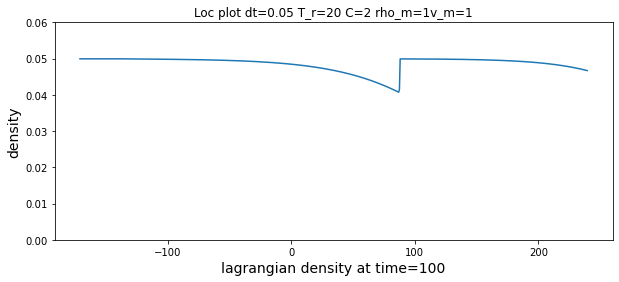

In [37]:
rho_matrix=np.zeros([n_cars-1,n_t_steps_traj])
rho_matrix=car_length/(loc_matrix[:n_cars-1,:]-loc_matrix[1:,:])
plt.figure(figsize=(10,4))
time =100
plt.plot(loc_matrix[1:,int(round(time/delta_gen))-1],rho_matrix[:,int(round(time/delta_gen))-1])
plt.ylim(0.0,.06)
plt.title('Loc plot dt=' + str(delta_gen) + " T_r=" + str(T_r)+ " C=" + str(C)+ " rho_m=" +str(rho_max) +"v_m=" +str(v_max))
plt.xlabel('lagrangian density at time='+str(time), fontsize=14)
plt.ylabel('density', fontsize=14)
plt.show()

In [39]:
loc_matrix[0]

array([150.        , 150.02503125, 150.05012492, ..., 239.92987935,
       239.9797109 , 240.02954287])